# Purpose and Objectives:

Welcome! In this notebook, we will be covering the basics of autoencoder architectures, in particular the (vanilla) autoencoder and the variatonal autoencoder architectures. Throughout the notebook, there will be a set of concept check questions. You can find the corresponding question in our supplemental conceptual document.

After completing this notebook, you will:


1.   Have a complete understanding of the general AE and VAE architectures
2.   Be able to implemting AEs and VAEs in Pytorch
3.   Evaluate the models' performance (loss/accuracy), denoising ability, and latent space through visualizations

*Note: It may be a good idea to review the basic principles of PCA as they will be referred to throughout the project*

## The Fundamental Setup of Autoencoder Architectures:

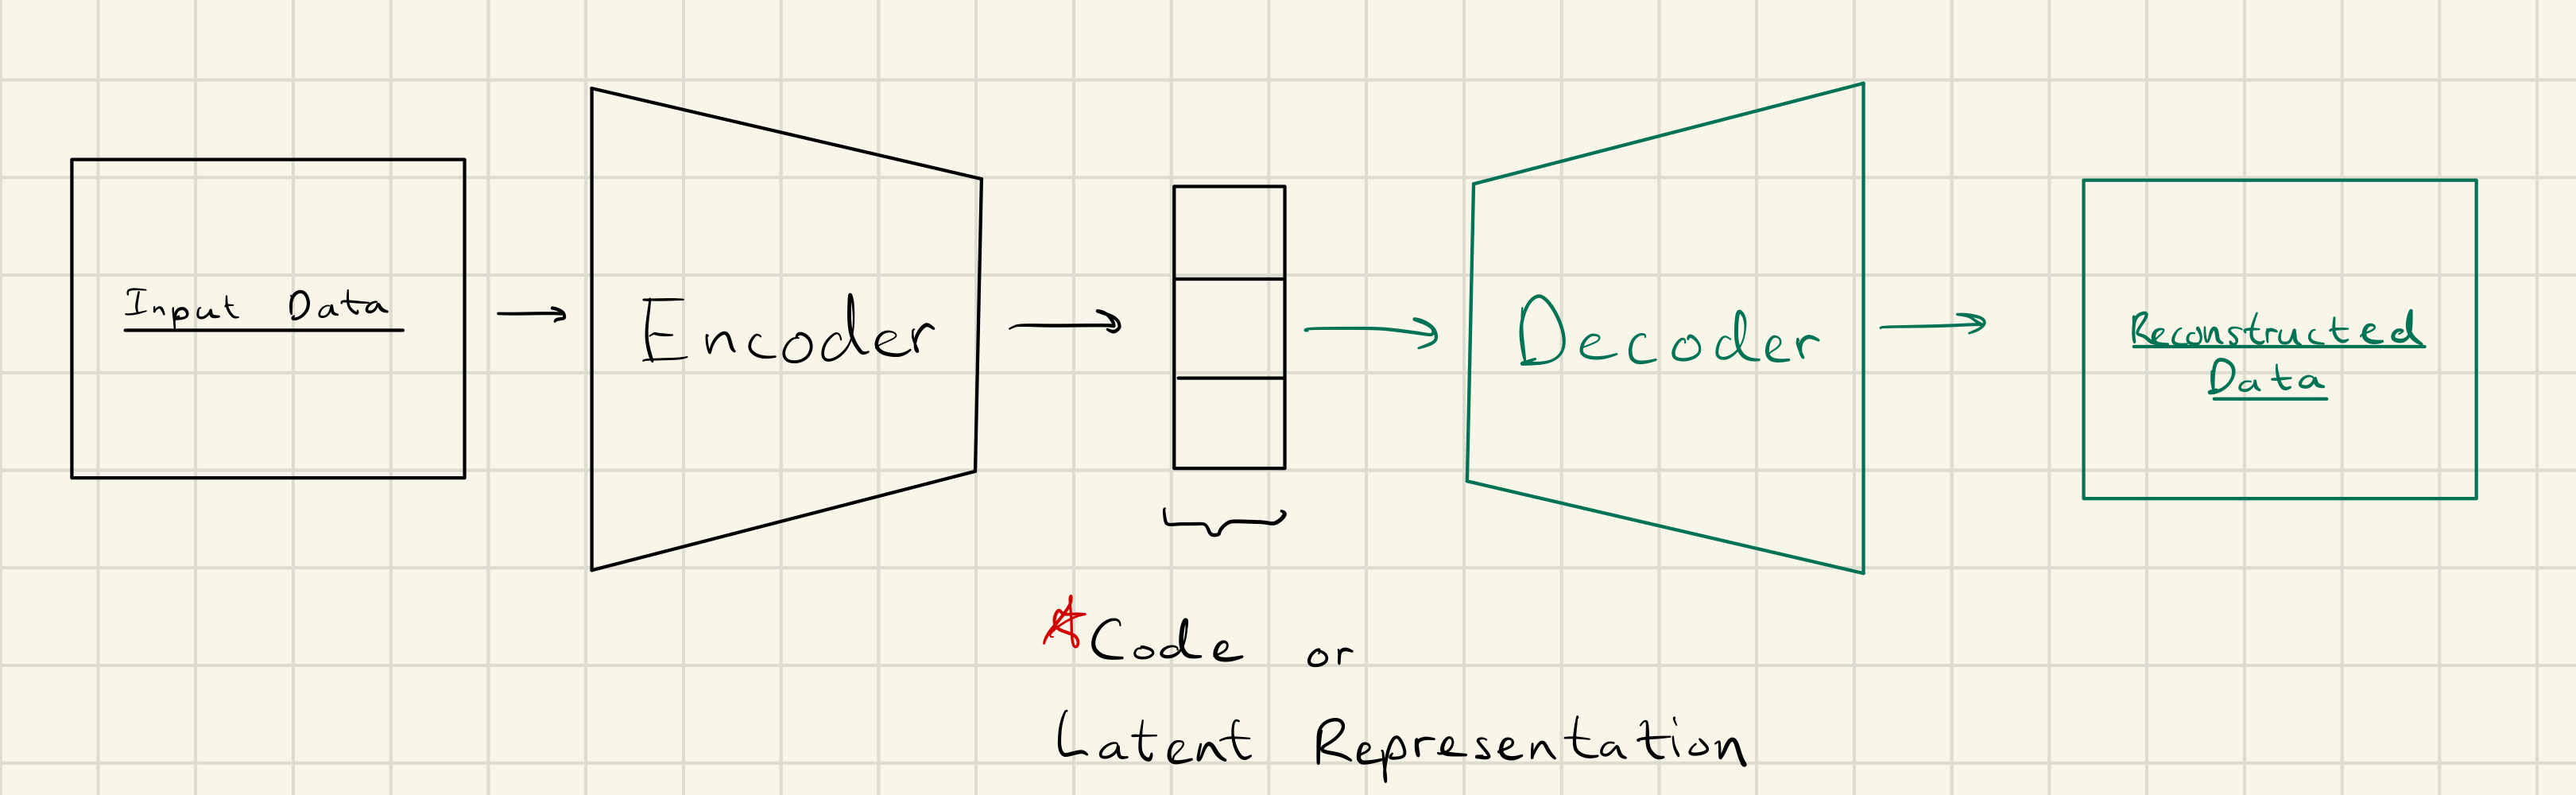

The above diagram represents the foundational architecture structure of autoencoders. As referenced in Hinton et. al., the purpose of autoencoders aligns very much with the motivations of PCA. One can consider the encoder to be a mapping from the high dimensional space of the input to the low-dimensional space of the latent representation. Similarly, the decoder *reconstructs* the low-dimensional represntation back into the original dimensionality. We discuss the purposes of this architecture in the next section.

### Concept Check 1.1.1

## Why Autoencoder Architectures? (Note to self: add images and figures later)

Autoencoder-style models have many different uses. We list several of the most notable ones here:

1.   **Dimensionality Reduction:** As mentioned in Hinton et. al., the *main* motivation for the AE architecutere is to turn "high-dimensional data" into "low dimensional codes". Adopting from the spirit of PCA, the encoder of an autoencoder can be thought of as a *nonlinear* map of the input data into the compressed space and the decoder an analogous yet opposite map that reconstructs the latent representation into the same dimensionality as the original input. Given sufficient data and computation, AEs can outperform PCA because *AEs are not limited to learning a linear representation of the data*. Datasets that feature high-dimensionality (e.g. biological/genetic data) can benefit from first applying AE dimensionality reduction before applying a later downstream task to the data. In this way, AE architectures can serve as a preprocessing step for other tasks.
2.   **Denoising:** Once again, similar to PCA, autoencoders can be utilized as preprocessing method for denoising data. Suppose we have an input vector $\vec{x}_i$ and we add some noise $\vec{\epsilon}$ to it. Then our minimization problem for the autoencoder becomes $\arg\min_{f, g} \sum_{i = 0}^{n}||\vec{x}_i - g(f(\vec{x}_i + \vec{\epsilon}))||^2$. From this objective, we see that an autoencoder used for denoising is motivated to ignore the noise.
3.   **Data Generation:** After properly training an autoencoder architecture, one can ignore the encoder half of the model and sample from the latent representation (or code) distribution. This sampled point can be passed through the decoder to hopefully generate new believable synthetic data.
4.   **Anomaly Detection:** Typically, the problem of anomaly detection involves classification of high dimensional data points (i.e. data with many features) into normal and anomalous samples (e.g. identifying anomolous credit card transaction). At a glance, the interpretations here can be similar to denoising, if we consider anomalies to be a type of "noise". There are many formulations and methematical tricks that can be used for anomaly detection. One common way is for the autoencoder to first learn a representation for the normal data. When running inference, the hope is that the reconstruction error can serve as a metric for evaluating whether a sample is anomolous or not. Intuitively, we would expect normal samples to be close in the low-dimensional space. On the contrary, anomalous samples would be expected to be far from the distribution of normal samples, yielding higher reconstruction error. Over the years many methods that leverage interpolation in the latent space, architectur improvements, and loss functions that incentivize clustering of normal and anomalous samples have been used. If you are curious to learn more about this field of research, refer to the following links: https://paperswithcode.com/task/anomaly-detection, https://github.com/yzhao062/anomaly-detection-resources

### Concept Check 1.1.2

## AE With Linear Layers on MNIST:

If the following imports don't succeed, please refer to the README to ensure that you properly handled all dependencies. Note: It may take some time to run the imports the first time.

In [38]:
import numpy as np

import sklearn
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.distributions import MultivariateNormal, Normal, Independent

import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from tqdm import tqdm

We will start with implementing a simple Vanilla Autoencoder model. We will train it on the MNIST dataset. First, let us set up the MNIST dataloaders.

### Set up and visualize data

In [59]:
# hyperparams
epochs = 3
lr = 1e-3
batch_size = 64

In [27]:
# data
train_dataset = datasets.MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='data/', train=False, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Labels: tensor([2, 0, 3, 4, 4, 1, 5, 4, 6, 6])


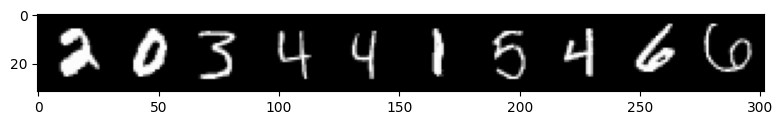

In [85]:
#Visualize the data:

#Grab first batch of images:
for images, labels in train_dataloader:
    break
    
#Print and show the first 10 samples:

print(f"Labels: {labels[0:10]}")
im = make_grid(images[:10], nrow=10)
plt.figure(figsize=(10,1))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC

Now that we have set up our data, let us construct the Vanilla Autoencoder with linear layers. We know that the input to the first layer should be the flattened MNIST data dimension. Following this, the layers of the AE encoder get iteratively smaller until the bottleneck (last layer of our encoder), which dictates the latent dimension size. The decoder is a mirror reflection of the encoder. Refer to [Hinton et. al.](https://www.science.org/doi/10.1126/science.1127647) for an idea on standard architecture if you are stuck. You may also utilize the helper code MLP, but it is not required.

### AE Model & Train

In [60]:
#Some Optional Helper Code:

def mlp(in_dim, out_dim, hidden_dim, n_layers):
    layers = []
    layers.append(nn.Linear(in_dim, hidden_dim))
    layers.append(nn.ReLU())
    for _ in range(n_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)

In [61]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z = self.encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat)
        return loss
    @staticmethod
    def loss(x, x_hat):
        #Mean-Squared Error Reconstruction Loss
        return ((x - x_hat) ** 2).mean()



The training loop is set up for you. Feel free to tinker with the hyperparameters + model architecture at this point if you would like.

In [62]:
#Training Loop for Autoencoder

# model and optimizer
ae = AE()
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
ae_train_losses = []
ae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_dataloader):
        x = x.reshape(x.shape[0], -1)  # flatten
        loss = ae.train_step(optimizer, x)
        ae_train_losses.append(loss.detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
          print(f"Training loss: {loss}")
    #ae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        loss = ae.test_step(X_test)
        ae_test_losses.append(loss.detach().numpy()) #loss every iteration
    #ae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 54%|███████████████████████████████████████████████████████▍                                              | 510/938 [00:10<00:07, 55.15it/s]

Training loss: 0.04645972326397896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 49.47it/s]


Epoch 2


  8%|███████▊                                                                                               | 71/938 [00:01<00:15, 54.70it/s]

Training loss: 0.03583343327045441


 61%|█████████████████████████████████████████████████████████████▊                                        | 569/938 [00:10<00:06, 54.60it/s]

Training loss: 0.031853966414928436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.31it/s]


Epoch 3


 14%|██████████████▏                                                                                       | 131/938 [00:02<00:14, 54.52it/s]

Training loss: 0.029667362570762634


 67%|████████████████████████████████████████████████████████████████████▌                                 | 631/938 [00:12<00:06, 50.17it/s]

Training loss: 0.032578013837337494


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.64it/s]


## VAE With Linear Layers on MNIST:

### AE Model & Train

In [63]:
class VAE(nn.Module):
    def __init__(self, input_dimension=1*28*28, latent_dimension=10):
        super().__init__()
        self.z_mean = mlp(input_dimension, latent_dimension, 256, 4)
        self.z_log_std = mlp(input_dimension, latent_dimension, 256, 4)
        self.decoder = mlp(latent_dimension, input_dimension, 512, 4)
    
    def _encode(self, x):
        z_mean = self.z_mean(x)
        z_log_std = self.z_log_std(x)

        # reparameterization trick
        z_std = torch.exp(z_log_std)
        eps = torch.randn_like(z_std)
        z = z_mean + eps * z_std

        # log prob
        # 'd' not sampled on purpose
        # to show reparameterization trick
        d = Independent(Normal(z_mean, z_std), 1)
        log_prob = d.log_prob(z)

        return z_mean + eps * z_std, log_prob
    
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat, z, log_prob)
        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=0.0001):
        reconst_loss = ((x - x_hat) ** 2).mean()

        z_dim = z.shape[-1]
        standard_normal = MultivariateNormal(torch.zeros(z_dim), 
                                             torch.eye(z_dim))
        kld_loss = (log_prob - standard_normal.log_prob(z)).mean()
        
        return reconst_loss + kl_weight * kld_loss

Again, feel free to tinker with the architecture or the hyperparameters if you would like.

In [64]:
#Training Loop for Autoencoder

# model and optimizer
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# train
vae_train_losses = []
vae_test_losses = []
step = 0
report_every = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_dataloader):
        x = x.reshape(x.shape[0], -1)  # flatten
        loss = vae.train_step(optimizer, x)
        vae_train_losses.append(loss.detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
          print(f"Training loss: {loss}")
    #vae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        loss = vae.test_step(X_test)
        vae_test_losses.append(loss.detach().numpy()) #loss every iteration
    #vae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 11%|███████████▍                                                                                          | 105/938 [00:05<00:27, 30.48it/s]

Training loss: 0.06544895470142365


 22%|██████████████████████▎                                                                               | 205/938 [00:08<00:22, 32.21it/s]

Training loss: 0.057016197592020035


 33%|█████████████████████████████████▏                                                                    | 305/938 [00:11<00:19, 32.25it/s]

Training loss: 0.05454249307513237


 43%|████████████████████████████████████████████                                                          | 405/938 [00:14<00:16, 32.34it/s]

Training loss: 0.05467895045876503


 54%|██████████████████████████████████████████████████████▉                                               | 505/938 [00:18<00:13, 32.35it/s]

Training loss: 0.046648405492305756


 64%|█████████████████████████████████████████████████████████████████▊                                    | 605/938 [00:21<00:10, 32.53it/s]

Training loss: 0.045734282582998276


 75%|████████████████████████████████████████████████████████████████████████████▋                         | 705/938 [00:24<00:07, 32.64it/s]

Training loss: 0.0425422228872776


 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 805/938 [00:27<00:04, 31.93it/s]

Training loss: 0.04253111034631729


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 905/938 [00:30<00:01, 30.80it/s]

Training loss: 0.044933583587408066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.80it/s]


Epoch 2


  7%|███████▍                                                                                               | 68/938 [00:02<00:27, 32.08it/s]

Training loss: 0.04354720190167427


 17%|█████████████████▊                                                                                    | 164/938 [00:05<00:25, 30.71it/s]

Training loss: 0.043240878731012344


 28%|████████████████████████████▋                                                                         | 264/938 [00:12<00:50, 13.46it/s]

Training loss: 0.03519497811794281


 39%|███████████████████████████████████████▋                                                              | 365/938 [00:16<00:18, 30.63it/s]

Training loss: 0.04056810587644577


 50%|██████████████████████████████████████████████████▋                                                   | 466/938 [00:21<00:18, 25.17it/s]

Training loss: 0.03788398578763008


 60%|█████████████████████████████████████████████████████████████▍                                        | 565/938 [00:26<00:12, 29.11it/s]

Training loss: 0.03940235823392868


 71%|████████████████████████████████████████████████████████████████████████▎                             | 665/938 [00:29<00:08, 32.30it/s]

Training loss: 0.04211598262190819


 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 765/938 [00:32<00:05, 32.31it/s]

Training loss: 0.03906743973493576


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 866/938 [00:36<00:02, 31.33it/s]

Training loss: 0.03864673897624016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:38<00:00, 24.36it/s]


Epoch 3


  3%|███                                                                                                    | 28/938 [00:00<00:28, 32.26it/s]

Training loss: 0.03895646333694458


 14%|█████████████▉                                                                                        | 128/938 [00:03<00:25, 32.22it/s]

Training loss: 0.038318656384944916


 24%|████████████████████████▊                                                                             | 228/938 [00:07<00:22, 31.96it/s]

Training loss: 0.03856661170721054


 35%|███████████████████████████████████▋                                                                  | 328/938 [00:10<00:21, 28.87it/s]

Training loss: 0.034175772219896317


 46%|██████████████████████████████████████████████▌                                                       | 428/938 [00:13<00:16, 31.78it/s]

Training loss: 0.0339086689054966


 56%|█████████████████████████████████████████████████████████▍                                            | 528/938 [00:16<00:12, 32.39it/s]

Training loss: 0.03229895979166031


 67%|████████████████████████████████████████████████████████████████████▎                                 | 628/938 [00:20<00:10, 29.65it/s]

Training loss: 0.033812060952186584


 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 728/938 [00:23<00:06, 31.00it/s]

Training loss: 0.034435078501701355


 88%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 830/938 [00:26<00:03, 31.53it/s]

Training loss: 0.03523331508040428


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 930/938 [00:29<00:00, 32.48it/s]

Training loss: 0.03473212197422981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:29<00:00, 31.32it/s]


## Ablations and Visualizations:

### 1. Loss Visualization:

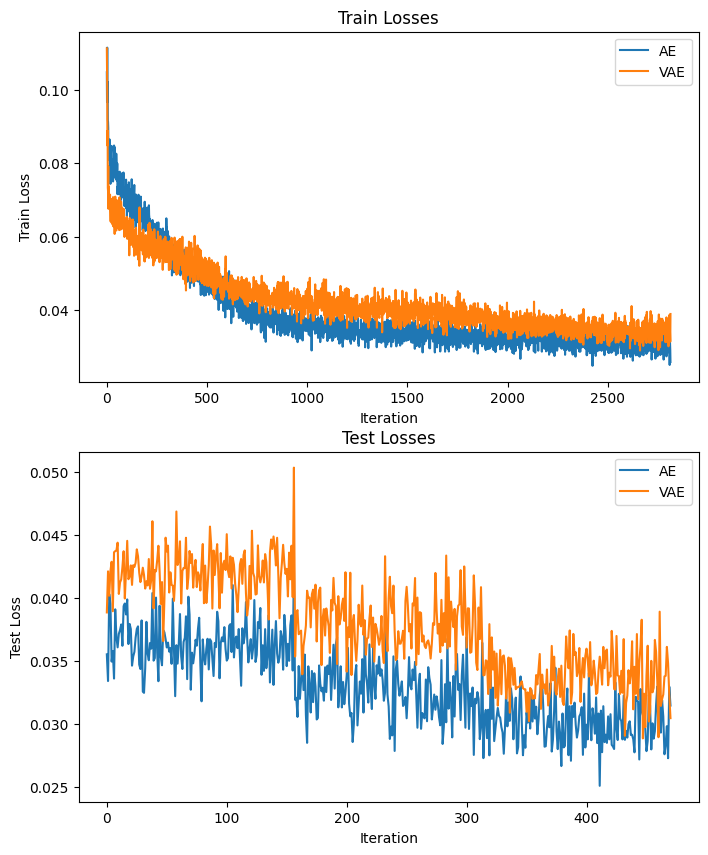

In [68]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()
    
    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

### 2. Visualize Reconstructed Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([2, 6, 7, 4, 3, 8, 8, 4, 1, 6])


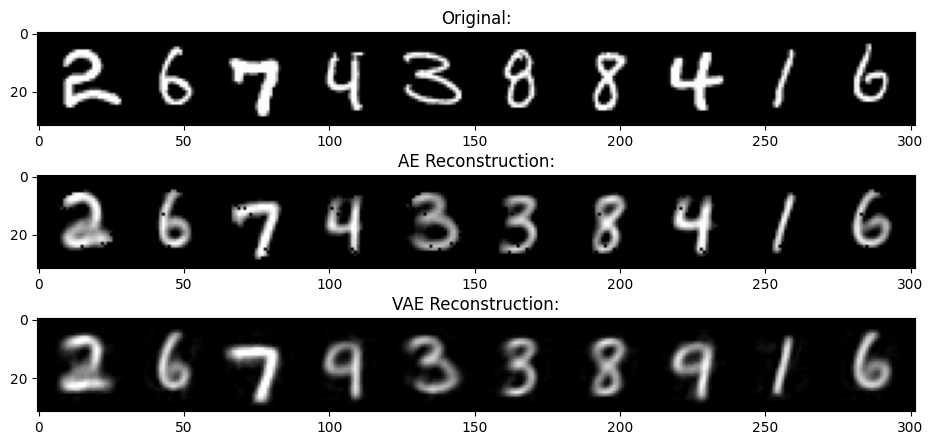

In [84]:
#Visualize the samples in bulk:

with torch.no_grad():
    #Grab first batch of images:
    for images, labels in test_dataloader:
        recon_ae = ae.decode(ae.encode(images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
        recon_vae = vae.decode(vae.encode(images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
        break


    #Print and show the first 10 samples:

    print(f"Labels: {labels[0:10]}")
    im = make_grid(images[:10], nrow=10)
    ae_im = make_grid(recon_ae[:10], nrow=10)
    vae_im = make_grid(recon_vae[:10], nrow=10)
    fig, ax = plt.subplots(3, figsize=(45,4.5))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")

    ax[1].imshow(np.transpose(ae_im.numpy(), (1, 2, 0)))
    ax[1].set_title("AE Reconstruction:")
    
    ax[2].imshow(np.transpose(vae_im.numpy(), (1, 2, 0)))
    ax[2].set_title("VAE Reconstruction:")

### 3. Visualizing the Latent Space:

### 4. AE/VAE Denoising:

### 5. Generating New Samples

In [ ]:
# analysis
num_samples = 512

viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

x, y = next(iter(viz_dataloader))
x = x.reshape(x.shape[0], -1)
z = ae.encode(x)
z = z.detach().numpy()

tsne = TSNE()
z = tsne.fit_transform(z)

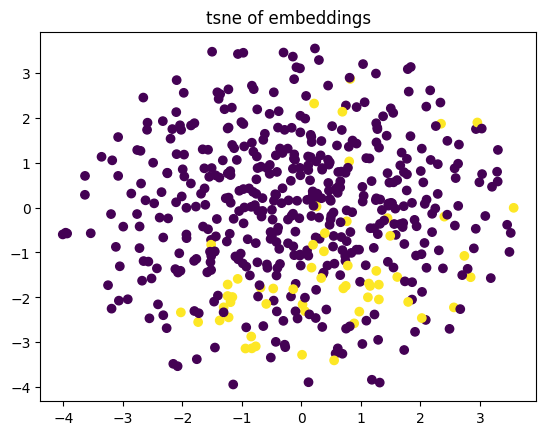

In [ ]:
viz_label = 0
plt.scatter(z[:, 0], z[:, 1], c=(y==viz_label))
plt.title('tsne of embeddings')
plt.show()

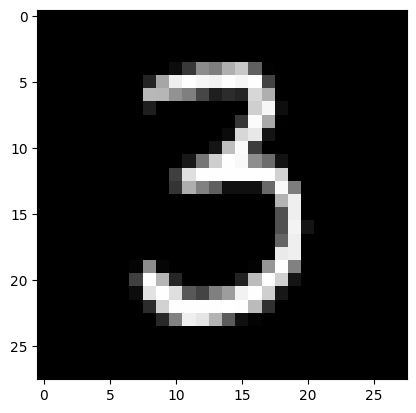

In [ ]:
plt.imshow(train_dataset[50][0].reshape(28, 28), cmap='gray')

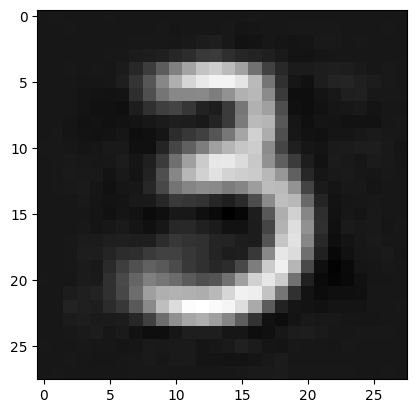

In [ ]:
encoded = ae.encode(train_dataset[50][0].flatten())
decoded = ae.decode(encoded)
plt.imshow(decoded.detach().numpy().reshape(28, 28), cmap='gray')

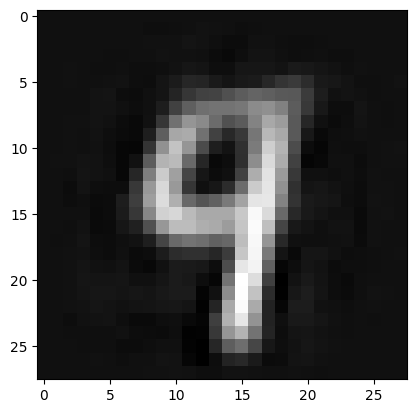

In [ ]:
import numpy as np
random_z = torch.normal(torch.zeros(300))
decoded = ae.decode(random_z.float())
plt.imshow(decoded.detach().numpy().reshape(28, 28), cmap='gray')

citations:
* https://github.com/AntixK/PyTorch-VAE
* 182 hw7

